<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_10%5D_Create_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

- 동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성

- 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다.

- 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플

- 33000개 중 3000개는 테스트 데이터로 분리하여 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 영구적인 라이브러리 설치하기위한 경로 지정
import os, sys

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env2', my_path)
sys.path.insert(0, my_path)

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install --target=$my_path--upgrade tensorflow

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [3]:
# 데이터 불러오기
file_path = '/content/drive/MyDrive/Aiffel/EX/EX10_txt/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep = '\t')
print('전체 샘플의 수 :', len(lines))
lines.sample(3)

전체 샘플의 수 : 194513


,eng,fra,cc
92197,Do you want some cherry pie?,Voulez-vous de la tarte aux cerises ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
134392,I won't be able to help you today.,Je ne pourrai pas vous aider aujourd'hui.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
79830,I'm not doing this for me.,Je ne fais pas ceci pour moi.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [4]:
# train 데이터는 조간에 따라 33000개만 사용
lines = lines[['eng', 'fra']][:33000]
lines_c = lines.copy()
# 분석에 문제가 생길경우를 대비라여 copy파일 생성
lines_c.sample(5)

,eng,fra
21656,What woke you up?,Qu'est-ce qui t'a réveillée ?
11320,Let's be frank.,Soyons francs.
14499,I won't risk it.,Je ne vais pas le risquer.
11359,Look after Tom.,Prends soin de Tom.
31092,No one is to leave.,Personne ne va s’en aller.


In [5]:
lines_c.iloc[:5]
# 다음 전처리에서 주의해야할 부문은 구두점의 띄어쓰기인것으로 판단된다.
# fra에서 어떤 구두점은 띄어쓰기가 되어있고 아닌것도 있다.

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


# Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [5]:
# 정규표현식을 사용한 데이터 전처리 
# 본 분석에서는 최종적으로 이 방법을 사용하였다.
# 이유는 회고에 작성
import re
def preprocess_sentence(sentence):
  sentence = sentence.str.replace(pat= r'([?.!,¿])', repl=r' \1', regex=True) #  구두점 분리
  sentence = sentence.str.lower() #  소문자로 바꿔준다.
  sentence = sentence.str.replace(pat=r"[^a-zA-Z!.?]+", repl =" ",regex=True) # -zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  sentence = sentence.str.replace(pat= r'[" "]+',repl=r" ", regex=True) # 여러개의 공백은 하나의 공백으로 바꿉니다
  sentence = sentence.str.split() # 띄어쓰기 적용
  return sentence

In [ ]:
# 다른 데이터 전처리 방식

# 전처리 기준
# 구두점(Punctuation)을 단어와 분리해주세요.
lines_c['eng'] = lines_c['eng'].str.replace(pat=r'([?.!,¿])', repl=r' \1', regex=True)
lines_c['fra'] = lines_c['fra'].str.replace(pat=r'([?.!,¿])', repl=r' \1', regex=True)

# 소문자로 바꿔주세요.
lines_c['eng'] = lines_c['eng'].str.lower()
lines_c['fra'] = lines_c['fra'].str.lower()

# 띄어쓰기 단위로 토큰를 수행하세요.
lines_c['eng'] = lines_c['eng'].str.split()
lines_c['fra'] = lines_c['fra'].str.split()

In [6]:
# Step1 전처리 적용
lines_c['eng'] = preprocess_sentence(lines_c['eng'])
lines_c['fra'] = preprocess_sentence(lines_c['fra'])

In [7]:
# 전처리 결과 확인
lines_c.iloc[:10]

,eng,fra
0,"[go, .]","[va, !]"
1,"[go, .]","[marche, .]"
2,"[go, .]","[bouge, !]"
3,"[hi, .]","[salut, !]"
4,"[hi, .]","[salut, .]"
5,"[run, !]","[cours, !]"
6,"[run, !]","[courez, !]"
7,"[run, !]","[prenez, vos, jambes, vos, cous, !]"
8,"[run, !]","[file, !]"
9,"[run, !]","[filez, !]"


In [8]:
# DF내부에 자료 형태 확인
type(lines_c['fra'][0])

list

# Step2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
- 원래는 2단계이지만 미리 토큰을 삽입하고 전처리를 수행

In [9]:
# 시작 토큰<\t>와 종료 토큰<\n>만들기
sos_token = '\t '
eos_token = ' \n' 
for sen in lines_c['fra']:
  sen.insert(0, sos_token)
  sen.append(eos_token)
print('전체 샘플의 수:', len(lines_c))
lines_c.head(3)

# 전처리 함수에서 마지막에 띄어쓰기를 적용하면서 각 index에 존재하는 데이터가 list가 되었다.
# 그러므로 for문을 사용하여 각 fra 컬럼에 시작 토큰과 종료 토큰을 삽입하였다.

전체 샘플의 수: 33000


,eng,fra
0,"[go, .]","[\t , va, !, \n]"
1,"[go, .]","[\t , marche, ., \n]"
2,"[go, .]","[\t , bouge, !, \n]"


In [10]:
# 특정행을 추출하여 전처리 결과 확인
lines_c.iloc[22248]
# 토큰화 전 : 'he is a good boy !'
# 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']
# 예시에 맞게 전처리가 잘 수행되었다.

eng                  [you, re, too, tense, .]
fra    [\t , vous, tes, trop, tendus, .,  \n]
Name: 22248, dtype: object

# Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

- [위키독스](https://wikidocs.net/31766)

- 토크나이저는 이 문서를 참고하여 진행하였습니다.
- 영어, 프랑스어 전부 토크나이저를 각각 생성한다.
- 임베딩 층에 사용 할 단어장, 인코더, 디코더, 패딩, validation data 준비

In [10]:
# tokenizer.texts_to_sequences()를 사용한 정수 시퀀스 변환 - 영어

eng_tokenizer = Tokenizer(split = '', filters= '') # 단어 단위로 Tokenizer를 생성합니다.
eng_tokenizer.fit_on_texts(lines_c.eng) # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines_c.eng) # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [11]:
# tokenizer.texts_to_sequences()를 사용한 정수 시퀀스 변환 - 불어

fra_tokenizer = Tokenizer(split = ' ', filters= '')   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines_c.fra)        # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines_c.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 75, 8, 2], [1, 378, 3, 2], [1, 718, 8, 2]]

In [12]:
# 단어장의 크기를 변수로 저장 0번 토큰을 고려하려 +1을 하고 저장
# 기존에 사용하던 전처리방식보다 더 작은 단어장을 만들어 내는데 성공하였다!
# 기존 단어장 개수 eng : 4900, fra : 9900
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4673
프랑스어 단어장의 크기 : 7462


In [14]:
# 각 단어 데이터의 최대 길이 구하기
# 패딩을 하기 위한 작업

max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

# 시퀀스 길이 차이가 약 2배이다.

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [15]:
print('전체 샘플의 수 :',len(lines_c))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4673
프랑스어 단어장의 크기 : 7462
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [16]:
# 언어별 인코더 디코더 준비하기
# 프랑스어 시퀀스는 2가지 버젼으로 나눈다.
# 하나는 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것입니다. 
# 그리고 다른 하나는 이전 스텝에서 언급했던 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위한 것

# 디코더의 입력으로 사용할 시퀀스는 < eos >토큰이 필요가 없고, 디코더의 출력과 비교할 시퀀스는 < sos >가 필요가 없기 때문입니다. 

encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[word for word in line if word != fra_tokenizer.word_index[eos_token]] for line in target_text]
# != 는 같지 않다는 뜻
# 즉 코드를 해석하면 target_text에 있는 line에서 프랑스 토크나이즈 word_index가 종료 토큰을 가지지 않는 word를 추출한다.
# 시작 토큰 제거
decoder_target = [[word for word in line if word != fra_tokenizer.word_index[sos_token]] for line in target_text]
# 즉 코드를 해석하면 target_text에 있는 line에서 프랑스 토크나이즈 word_index가 시작 토큰을 가지지 않는 word를 추출한다

In [17]:
# 디코더의 입력과 출력을 각각 출력해봅시다.
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 75, 8], [1, 378, 3], [1, 718, 8]]
[[75, 8, 2], [378, 3, 2], [718, 8, 2]]


In [18]:
# 패딩 진행하기
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

# 정상적으로 패딩이 수행되었다.

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [19]:
# encoder_input 샘플을 출력해서 확인해보기
print((encoder_input[:5]))

[[ 29   1   0   0   0   0   0   0]
 [ 29   1   0   0   0   0   0   0]
 [ 29   1   0   0   0   0   0   0]
 [764   1   0   0   0   0   0   0]
 [764   1   0   0   0   0   0   0]]


In [20]:
# decoder_input 샘플을 출력해서 확인해보기
print(decoder_input[:5])

[[  1  75   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 378   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 718   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 747   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 747   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [21]:
# decoder_target 샘플을 출력해서 확인해보기
print(decoder_target[:5])

[[ 75   8   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [378   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [718   8   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [747   8   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [747   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [19]:
#  validation data 생성

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))
print('영어 테스트데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

# 데이터 셋 분리가 성공적으로 이루어졌다.

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 17)
영어 테스트데이터의 크기(shape) : (3000, 8)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 17)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 17)


# Step 4. 임베딩 층(Embedding layer) 사용하기

- [위키독스](https://wikidocs.net/33793)
- 인코더, 디코더 구현은 이 문서를 참고하여 진행하였습니다.

In [20]:
# 필요한 라이브러리 불러오기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [21]:
# 임베딩 벡터의 차원과 은닉 상태의 크기 지정
embedding_dim = 256
hidden_units = 256

In [22]:
# 인코더 구성

# 인코더에서 사용할 임베딩 층

# 입력 텐서 생성
encoder_inputs = Input(shape=(None,))

# 임베딩 층
enc_emb =  Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)

# 패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb) 

# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units, return_state=True)

# 은닉 상태와 셀 상태를 리턴
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

# 인코더의 은닉 상태와 셀 상태를 저장
encoder_states = [state_h, state_c] 

In [23]:
# 디코더 구성

# 디코더에서 사용할 임베딩 층

decoder_inputs = Input(shape=(None,))

# 임베딩 층
dec_emb_layer = Embedding(fra_vocab_size, hidden_units) 

# 패딩 0은 연산에서 제외
dec_emb = dec_emb_layer(decoder_inputs) 

dec_masking = Masking(mask_value=0.0)(dec_emb)

In [24]:
# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences= True, return_state= True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

# 디코더 출력층 설계
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [25]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# loss 기준을 바꾼 이유는 decoder_outputs의 경우에는 원-핫 인코딩을 하지않았습니다.
# 원-핫 인코딩을 하지 않은 상태에서는 다중 클래스 분류를 할때는 sparse_categorical_crossentropy로 설정해야합니다.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1196288     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1910272     ['input_2[0][0]']                
                                                                                              

In [26]:
# 모델 학습
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=30)

Epoch 1/30
235/235 [==============================] - 19s 48ms/step - loss: 1.8120 - accuracy: 0.7220 - val_loss: 1.7218 - val_accuracy: 0.7390
Epoch 2/30
235/235 [==============================] - 9s 38ms/step - loss: 1.3021 - accuracy: 0.7856 - val_loss: 1.4820 - val_accuracy: 0.7678
Epoch 3/30
235/235 [==============================] - 9s 38ms/step - loss: 1.1147 - accuracy: 0.8141 - val_loss: 1.3586 - val_accuracy: 0.7871
Epoch 4/30
235/235 [==============================] - 9s 37ms/step - loss: 0.9997 - accuracy: 0.8302 - val_loss: 1.2773 - val_accuracy: 0.7989
Epoch 5/30
235/235 [==============================] - 9s 37ms/step - loss: 0.9107 - accuracy: 0.8422 - val_loss: 1.2090 - val_accuracy: 0.8084
Epoch 6/30
235/235 [==============================] - 9s 36ms/step - loss: 0.8391 - accuracy: 0.8514 - val_loss: 1.1614 - val_accuracy: 0.8154
Epoch 7/30
235/235 [==============================] - 9s 36ms/step - loss: 0.7802 - accuracy: 0.8590 - val_loss: 1.1302 - val_accuracy: 0.817

In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


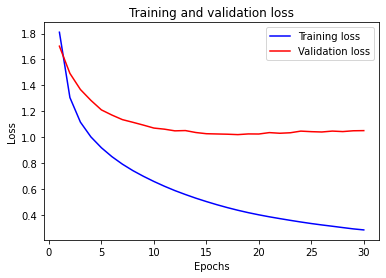

In [32]:
# Loss, Accuracy 그래프 시각화 

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "b"는 "파란색 실선"입니다
plt.plot(epochs, loss, 'b', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 학습과 검증의 loss가 전부 안정적으로 감소하고있다.

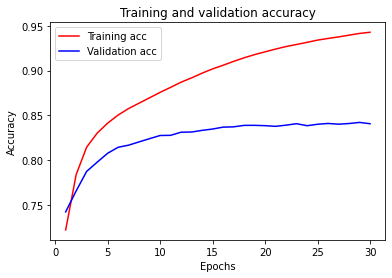

In [33]:
plt.clf()   # 그림을 초기화합니다
# "r"는 "빨간색 실선"입니다
plt.plot(epochs, acc, 'r', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습과 검증의 accuracy가 전부 안정적으로 증가하고있다.

# Step 5. 모델 구현하기

- seq2seq는 교사 강요가 테스트 과정에서 동작이 다르다
- 그러므로 테스트 과정에서 모델을 다시 설계할 필요가있다.

In [28]:
# 인코더 모델
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1196288   
                                                                 
 masking (Masking)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,721,600
Trainable params: 1,721,600
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 디코더 설계
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_units,))

# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_units,))

# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

In [30]:
# 디코더 출력층 재설계
decoder_outputs2  = decoder_softmax_layer(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2 ] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1910272     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

In [31]:
# 단어 사전 준비하기
eng2idx = eng_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
fra2idx = fra_tokenizer.word_index
idx2fra = fra_tokenizer.index_word

NameError: ignored

In [47]:
# decode_sequence() 구현

def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra2idx[sos_token]

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == eos_token or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

  # 이 부분은 토큰은 전부 sos_token, eos_token으로 넣어주었다.
  # 그 이유는 '\t' key error가 발생하였는데 알고보니 word_index에 '\t '공란이 추가된 채 삽입되어있었다.

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx[sos_token] and encoded_word != fra2idx[eos_token]):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

# Step 6. 모델 평가하기

In [55]:
# 출력 결과 테스트하기 (train data set)
import numpy as np

for seq_index in [3,50,250,300,2501]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-1])
  print("-"*50)

입력문장 : hi . 
정답문장 : salut ! 
번역문장 : salut .  
--------------------------------------------------
입력문장 : hello ! 
정답문장 : salut ! 
번역문장 : salut !  
--------------------------------------------------
입력문장 : get out . 
정답문장 : d gagez ! 
번역문장 : sortez .  
--------------------------------------------------
입력문장 : help me ! 
정답문장 : aide moi ! 
번역문장 : aide moi !  
--------------------------------------------------
입력문장 : tom saw us . 
정답문장 : tom nous voyait . 
번역문장 : tom nous a vu .  
--------------------------------------------------


In [56]:
# 출력 결과 테스트하기 (test data set)
import numpy as np

for seq_index in [3,50,250,300,2501]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-1])
  print("-"*50)

입력문장 : i want my key back . 
정답문장 : je veux que vous me rendiez ma cl . 
번역문장 : je veux ma famille .  
--------------------------------------------------
입력문장 : i was almost right . 
정답문장 : j avais presque raison . 
번역문장 : j ai t heureuse .  
--------------------------------------------------
입력문장 : i m always careful . 
정답문장 : je suis toujours prudent . 
번역문장 : je suis toujours ici .  
--------------------------------------------------
입력문장 : i m going to flunk . 
정답문장 : je vais me planter . 
번역문장 : je vais y aller .  
--------------------------------------------------
입력문장 : tom skipped school . 
정답문장 : tom a s ch les cours . 
번역문장 : tom semble ais a gagn .  
--------------------------------------------------


# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 첫 번째 시도에서 test 번역결과가 너무 좋지 않았습니다. 다른 사람과 비교하였을때 저의 단어장의 크기가 약 1500개가 더 많았습니다. 동일한 전처리 후 이렇게 단어장 크기가 달라질수있을까? 라는 의문이 들었습니다. 그래서 전처리 방식을 바꿔보았습니다.

 (2) 프랑스어 악센트는 제거해야하는가?
 - 이 부분이 궁금하여 퍼실님께 질문을 드려보았다. 프랑스어는 악센트를 문자에 표현하기때문에 지우면 안된다고하셨다. 나중에 다른 언어를 이용하여 번역기를 만들어본다면 이런 디테일을 챙기는것이 중요하다고 생각했다.

 (3) 출력결과 테스트에서 키 에러가 발생하여 해결하기 위하여 word_index를 확인해보니 토큰의 공백이 포함되어있었다. 전처리를 다시하기는 힘들어서 함수안에 토큰을 토큰명으로 전부 수정하니 정상적으로 잘 작동되었다.
 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 단어장의 개수에 따른 번역 결과 품질 차이가 많이 난다는 것을 알게되었습니다.
- 첫번째 전처리 시도에서는 fra 단어장 크기가 9900이었습니다. 테스트 데이터 셋에서 번역 결과가 너무 엉망이었습니다. 그래서 다른 자연어처리 프로젝트에서 사용한 전처리 방법을 더 추가해보았고 fra 단어장 크기를 약 7600개까지 줄이는데 성공했습니다.

(2) DataFrame 안에 data가 전부 List일때 data를 추가하는 방법을 알게되었습니다.
- 루브릭의 전처리 기준으로 맞추다보니 전체적인 data 형태를 DataFrame으로 나왔으나 각각의 data는 List 형태였습니다. 물론 토큰을 먼저 넣어서 전처리를 하는 방법도 있었지만 토큰을 먼저 넣게된다면 토큰이 계속 사라지는 문제를 겪었습니다.
그래서 저는 리스트에 insert와 append를 for문을 사용해서 넣어보자고 생각히였습니다. 결과는 예상과 일치하게 잘 수행됐습니다. 기본적인 파이썬 문법을 이렇게 활용할 수 있어서 더 기억에 남을거같습니다.





참조

(1) [위키북스 자연어처리 입문 : word-level 번역기 만들기](https://wikidocs.net/86900)

(2) [seq2seq 이론 복습 자료](https://wikidocs.net/24996)
